### Подготовительный этап.

In [2]:
!apt install libspatialindex-dev
!pip install osmnx

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
0 upgraded, 3 newly installed, 0 to remove and 31 not upgraded.
Need to get 555 kB of archives.
After this operation, 3,308 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-dev amd64 1.8.5-5 [285 kB]
Fetched 555 kB in 2s (252 kB/s)
Selecting previously unselected package libspatialindex4v5:amd64.
(Reading database ... 144433 files and directories currently installed.)
Preparing to unpack .../libspatialindex4v5_1.8.5-5_

In [0]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from random import random
import csv
import json # пока писать будет в json, но если что переделаем

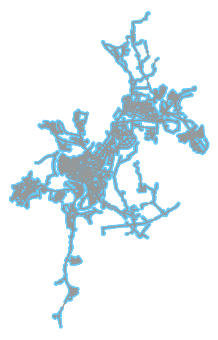

In [4]:
place = {'city' : 'Ufa',
         'country' : 'Russia'}
G = ox.graph_from_place(place, network_type='drive', simplify=False)

fig, ax = ox.plot_graph(G)

In [0]:
# нахождение расстояний между смежными узлами
a = G.adj
dictionary = {}
i = 0
for key, value in a.items():
    if i == 10:
        break
    for key_a, value_a in value.items():

        if key not in dictionary:
            dictionary[key] = [{key_a:value_a[0]['length']}]
        else:
            dictionary[key].append({key_a:value_a[0]['length']})                  

In [0]:
nodes_list = list(G.nodes())

In [0]:
# вытаскиваем больницы и дома
buildings = ox.footprints.footprints_from_place(place, footprint_type='building', retain_invalid=False, which_result=1)


hospital = []
apartments = []
n = 10000
build = buildings.head(n)['building'].to_dict()

for key,value in build.items():
    if value == 'hospital':
        hospital.append(key)
    elif value == 'apartments':
        apartments.append(key)

hospitals = hospital[:10]
apartments = apartments[:100]

# print(hospitals)
# print(apartments)

In [0]:
# для каждой больницы и дома находим соответсвующие им (ближайшие) ноды на графе
a = buildings.head(n).to_dict()
hospitals_dict = {}
apartments_dict = {}

for i in hospitals:   
    bounds = a['geometry'][i].bounds
    nearest_node = ox.get_nearest_node(G, ((bounds[1]+bounds[3])/2, (bounds[0]+bounds[2])/2))
    hospitals_dict[i] = nearest_node
    # print(i, nearest_node)

for i in apartments:
    bounds = a['geometry'][i].bounds    
    nearest_node = ox.get_nearest_node(G, ((bounds[1]+bounds[3])/2, (bounds[0]+bounds[2])/2))
    apartments_dict[i] = nearest_node
    # print(i, nearest_node)

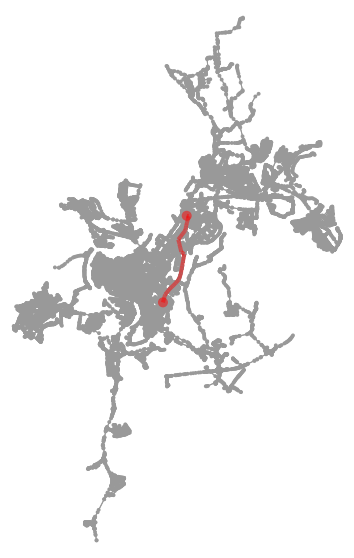

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8d26d789e8>)

In [9]:
# пример визуализации кратчайших путей (точки взяты из предыдущего пункта)
route = nx.shortest_path(G,
                         892683760,
                         498826321, 
                         weight='length') 

ox.plot_graph_route(G, route, fig_height=10, fig_width=10)

In [0]:
# матрица смежностти в пандас
G_pd = nx.to_pandas_adjacency(G)

# можно записать в эксель и это даже работает!!
# G_pd.to_csv('matrix_adjacency_pandas.csv')

In [0]:
# переводив в нампаевский ndarray
# !запускать только один раз!
G_pd = G_pd.values

In [12]:
print(G_pd)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [0]:
# пишем полученный ndarray в csv
with open('matrix_adjacency.csv', "w", newline='') as csv_file:
    writer = csv.writer(csv_file, delimiter=',')
    for line in G_pd:
        writer.writerow(line)

In [0]:
# вместо нулей и единиц записываем в матрицу смежности расстояния между нодами (по формуле из файла)
for i in range(len(G_pd)):
    for j in range(len(G_pd)):
        if G_pd[i][j] == 1:
            for k in range(len(dictionary[nodes_list[i]])):
                if nodes_list[j] in dictionary[nodes_list[i]][k].keys():
                    distance = dictionary[nodes_list[i]][k][nodes_list[j]]   
            weight = 1
            if nodes_list[i] in hospitals_dict.values():
                weight = random() + 1
            G_pd[i][j] = distance * weight
# если ребра между нодами нет, то заполняем большими расстояниями (для нахождения крастчайших путей)
# возможно, можно придумать что-то менее костыльное
        if G_pd[i][j] == 0:
            G_pd[i][j] = 10**10

In [0]:
# Создаем словарь {id узла}: {его index в списке узлов}
nodes_numbers = {}
for index,i in enumerate(nodes_list):
    nodes_numbers[i]=index 

In [0]:
# делаем листы для использования Дейсктры 
hospital_values = list(hospitals_dict.values())
apartments_values = list(apartments_dict.values())

In [0]:
# создаем общий лист, чтобы сделать и дома, и больницы одновременно
new_nodes = apartments_values + hospital_values

In [0]:
# матрица в которой будем хранить значения кратчайших путей
short_path_matrix = np.zeros((len(new_nodes), len(new_nodes)))

# словарь, который хранит дерево кратчайших расстояний из вершины i
pred_dict = {}

index_nodes = [] # индексы узлов домов
for i in new_nodes:
    index_nodes.append(nodes_numbers[i]) # в качестве индекса номер, соответствующий id узла

In [0]:
# пример работы дейкстры)
import time
start = time.time()
p = {}
pred, dist = nx.dijkstra_predecessor_and_distance(G, 892683760)
# вывод дерева кратчайших путей из вершины 0, где у каждого узла указан предок
print(p)
print(time.time() - start)

{892683760: [], 3221812952: [892683760], 3700686081: [892683760], 1388755403: [892683760], 1393833498: [3221812952], 1388738465: [3700686081], 2334187990: [1388755403], 1065658694: [1393833498], 1388754265: [1388738465], 426638625: [2334187990], 1385663987: [1065658694], 2334187940: [1065658694], 1858125328: [1388754265], 1331908783: [426638625], 1483187119: [426638625], 3700686076: [1385663987], 2334187973: [2334187940], 1328100492: [1858125328], 2334188018: [1331908783], 1331908668: [1483187119], 1385661309: [3700686076], 2334187989: [2334187973], 3700686099: [1328100492], 425560492: [1328100492], 2334188054: [2334188018], 1393784512: [1331908668], 3700686070: [1385661309], 1065658060: [2334187989], 1437631651: [3700686099], 1328078379: [425560492], 1437631627: [425560492], 5720808956: [2334188054], 1063825663: [1393784512], 3221334367: [3700686070], 4325392949: [1065658060], 3700686091: [1437631651], 2401122764: [1328078379], 1437631611: [1437631627], 2334188065: [5720808956], 13938

In [0]:
# переписанная дейкстра из nx от Милены

from heapq import heappush, heappop

def dijkstra_heap (G, source):
    
    G_succ = G._succ 
    push = heappush
    pop = heappop
    weight = lambda u, v, d: min(attr.get(weight, 1) for attr in d.values()) #понятия не имею что происходит в этой строчке увы

    pred={}
    dist = {}  # dictionary of final distances
    seen = {}  # минимальное расстояние до ключа-точки
    # fringe is heapq with 2-tuples (distance,node)
    fringe = []

    seen[source] = 0
    push(fringe, (0, source))
    while fringe:
        (d, v) = pop(fringe)
        if v in dist:
            continue  # already searched this node.
        dist[v] = d
        for u, e in G_succ[v].items():
            cost = weight(v, u, e) #v - источник, u - точка, e - ребро (мультиграф же,значит их несколько)
            if cost is None: # видимо если ребра нет, возможно стоит заменить на бесконечное значение
                continue
            vu_dist = dist[v] + cost
            if u not in seen or vu_dist < seen[u]: #если мы еще не искали путь до u или новое расстояние меньше найденного
                seen[u] = vu_dist
                push(fringe, (vu_dist, u))
                if v in pred:
                  pred[u] = np.append(pred[v],v)
                else:
                  pred[u] = np.array([v])

    return dist, pred

In [19]:
# проверка работы
import time
start = time.time()
for i in range(len(new_nodes)):

  dist, pred = dijkstra_heap(G, nodes_list[i])
  # я слегка запуталась во всех этих матрицах не уверена что тут подаются те точки
  pred_dict[nodes_list[i]] = pred
  # в данном случае это словарь, где каждой точке-источнику соответствует словарь конечных точек маршрута 
  # и в качестве значений перечисления вершин, по которым можно добраться до них 
  for j in range(len(new_nodes)):
    short_path_matrix[i][j] = dist[nodes_list[j]]

print(time.time() - start)
        
print(short_path_matrix)

34.19125580787659
[[  0.  56.  43. ... 257. 256.  55.]
 [ 60.   0.  29. ... 217. 216.  14.]
 [ 47.  29.   0. ... 230. 229.  28.]
 ...
 [284. 233. 253. ...   0.   1. 238.]
 [283. 232. 252. ...   1.   0. 237.]
 [ 59.  14.  28. ... 222. 221.   0.]]


In [0]:
#когда я в прошлый раз пыталась вывести вообще всех предков для всех точек для всех источников у меня все упало
#даже если я пытаюсь вывести всех предков для одного источника у меня все падает
#лучше выводить конкретных предков для конкретного источника
print(pred_dict[nodes_list[0]][nodes_list[1]])
print(nodes_list[0])

In [0]:
# если нет кратчайшего пути, то ставим очень большое число
for i in range(len(new_nodes)):
    for j in range(len(new_nodes)):
        if short_path_matrix[i][j] == 0 and i!=j:
            short_path_matrix[i][j] = 10**10

In [0]:
# записываем матрицу кратчайших путей в csv
with open('matrix_dijkstra.csv', "w", newline='') as csv_file:
    writer = csv.writer(csv_file, delimiter=',')
    for line in short_path_matrix:
        writer.writerow(line)

In [0]:
# функция, находящая кратчайший путь между двумя вершинами a и b 
# Эта функция находит всех предков по последнему 
#(нас она не интересует так как мы это делаем внутри функции) -- Милена
def find_short_path(pred_dict, index_a, index_b):
    path = []
    path.append(index_b)
    temp = index_b
    while pred_dict[index_a][temp] != index_a:
        path.append(pred_dict[index_a][temp])
        temp = pred_dict[index_a][temp]
    path.append(index_a)
    path.reverse()
    return path

In [0]:
# пишем в json файл дерево кратчайших путей
with open('short_path_tree.json', 'w') as f:
    json.dump(pred_dict, f)

In [0]:
# то же самое, что предыдущее, но для всех путей
def find_all_short_path(pred_dict):
    short_paths = {}
    for i in pred_dict.keys():
        path = {}
        for j in pred_dict[i].keys():
            path[j] = find_short_path(pred_dict, i, j)
        short_paths[i] = path
    return short_paths

short_paths = find_all_short_path(pred_dict)

In [0]:
# пишем в json все кратчайшие пути
with open('short_paths.json', 'w') as f:
    json.dump(short_paths, f)

In [0]:
# получение ключа 
def get_key(d, value):
    for k, v in d.items():
        if v == value:
            return k
    return -1

# получение айди
def get_id(nodes_numbers, index_nodes, i):
    temp = get_key(nodes_numbers, index_nodes[i])
    if temp == -1:
        return "Не найдено id узла"
    else:
        return temp

### Первое задание (пункты подписаны).

In [0]:
from numpy import genfromtxt
# считываем матрицу кратчайгих расстояний из csv файла
data = genfromtxt('matrix_adjacency_final.csv', delimiter=',') 

### Пункт 1.а 
Для каждого дома определить ближайший от узла объект (путь “туда”), ближайший к объекту узел (путь “обратно”), объект, расстояние до которого и обратно минимально (“туда и обратно”).

In [0]:
# функция нахождения ближайшей больницы
def find_nearest_hospitals(dist_matrix, apart_count=100):
    nearest_hosp_list = [[-1 for i in range(3)] for j in range(apart_count)]
    for i in range(apart_count):
        nearest_hosp_list[i][0] = np.argmin(dist_matrix[i][apart_count:]) + apart_count
        nearest_hosp_list[i][1] = np.argmin(np.array(dist_matrix[apart_count:]).transpose()[i]) + apart_count
        tuda = dist_matrix[i][apart_count:]
        suda = np.array(dist_matrix[apart_count:]).transpose()[i]
        nearest_hosp_list[i][2] = np.argmin(tuda + suda) + apart_count
    return nearest_hosp_list

In [0]:
# запуск программы
find_nearest_hospitals(data)

### Пункт 1.b
Для каждого дома определить объекты, расположенные не далее, чем в X км для каждого из трех вариантов “туда”, “обратно”, “туда и обратно”.

In [0]:
# возвращаемый список содержит списки с 3-мя списками индексов подходящих объектов: "туда", "обратно" и "туда и обратно" 
# содержат своё количество индексов - это списки второго уровня,индекс списка первого уровня соответствует индексу дома во входной матрице расстояний. 
def find_in_radius(dist_matrix, radius, apart_count=100):
    permissible_hosps = [[[] for i in range(3)] for j in range(apart_count)]
    for i in range(apart_count):
        for j in range(apart_count, len(dist_matrix)):
            if dist_matrix[i][j] <= radius:
                permissible_hosps[i][0].append(j)
            if dist_matrix[j][i] <= radius:
                permissible_hosps[i][1].append(j)
            if dist_matrix[i][j] + dist_matrix[j][i] <= radius:
                permissible_hosps[i][2].append(j)
    return permissible_hosps

In [0]:
# запуск программы, radius произвольный
radius = 500
find_in_radius(data, radius)

### Пункт 2
Определить, какой из объектов расположен так, что расстояние между ним и самым дальним домом минимально (“туда”, “обратно”, “туда и обратно”).

In [0]:
# возвращаемый список содержит три больницы - [ "туда", "обратно", "туда и обратно" ], где "туда" – из дома в больницу
def get_optimal_hospitals(dist_matrix, apart_count=100):
    optimal_hosps = []
    tuda = np.array(dist_matrix[:apart_count]).transpose()[apart_count:]
    optimal_hosps.append(np.argmin(np.amax(tuda, 1)) + apart_count)
    suda = np.array(dist_matrix[apart_count:])[:, :apart_count]
    optimal_hosps.append(np.argmin(np.amax(suda, 1)) + apart_count)
    tuda_suda = tuda + suda
    optimal_hosps.append(np.argmin(np.amax(tuda_suda, 1)) + apart_count)
    return optimal_hosps

In [0]:
# запуск программы
opt = get_optimal_hospitals(data)

### Пункт 3

Определить, для какого объекта инфраструктуры сумма кратчайших расстояний от него до всех домов минимальна.

In [0]:
# возвращает id больницы
def min_sum_hosp(dist_matrix, apart_count=100):
    dist_sums = np.array(dist_matrix[apart_count:])[:, :apart_count]
    dist_sums = np.sum(dist_sums, 1)
    min_hosp = np.argmin(dist_sums) + apart_count
    hosp_id = get_id(nodes_numbers, index_nodes, min_hosp)
    return hosp_id

In [0]:
# запуск программы
min_hosp_id = min_sum_hosp(data)

### Пункт 4
Определить, для какого объекта инфраструктуры построенное дерево кратчайших путей имеет минимальный вес.

In [0]:
# считаем вес дерева кратчаших путей
def tree_weight(tree, root, matrix):
    weight = 0
    for i in tree[root].keys():
        j = tree[root][i]
        weight += matrix[j][i]
    return weight

# нахождение дерева минимального веса, где корни - больницы
def minimal_tree_hospitals(tree, matrix, hospitals):
    min_value = 10**10
    root = 0
    for i in hospitals:
        temp = tree_weight(tree, str(i), matrix)
        print(i, temp)
        if temp < min_value:
            min_value = temp
            root = i
    return root

In [0]:
# загружаем наши деревья кратчайших путей
with open('short_path_tree.json') as f:
    short_path_tree = json.load(f)

# берем список деревьев (они в конце index_nodes, поэтому берем последние 10)
hospitals = index_nodes[:-10]

# ищем номер корня дерева минимального веса из больниц
min_tree_root = minimal_tree_hospitals(short_path_tree, data, hospitals)
hosp_id = get_id(nodes_numbers, index_nodes, min_tree_root)